In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from scipy.stats import uniform
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy.stats import randint
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('credit_customers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [3]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [4]:
features = ['checking_status','credit_history', 'purpose', 'savings_status', 'employment', 'personal_status',
            'property_magnitude', 'other_payment_plans', 'housing', 'job', 
            'foreign_worker', 'own_telephone', 'other_parties', 'class']

for i in features:
  labelEncoder = LabelEncoder()
  df[i] = labelEncoder.fit_transform(df[i])

y = df['class']
X = df.drop(['class'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(y.unique())

[1 0]


In [5]:
escalado = MinMaxScaler()

escalado.fit(X_train)
X_train = escalado.transform(X_train)
X_test = escalado.transform(X_test)

In [6]:
tree_clf = DecisionTreeClassifier()
parameters = {"max_depth": [3, None],
              "max_features": randint(1, 4),
              "min_samples_leaf": randint(1, 10),
              "criterion": ["gini", "entropy"]}
clf = RandomizedSearchCV(tree_clf, 
                   parameters,
                   scoring = 'accuracy',
                   cv = 5,
                   return_train_score =  True)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002160915F280>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000216090F0A60>},
                   return_train_score=True, scoring='accuracy')

In [7]:
y_pred = clf.predict(X_test)
print('El accuracy del arbol en el conjunto de test es de ' + str(accuracy_score(y_test, y_pred)))
print('Los mejores parametros fueron: ')
print(clf.best_params_)

El accuracy del arbol en el conjunto de test es de 0.7166666666666667
Los mejores parametros fueron: 
{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2}


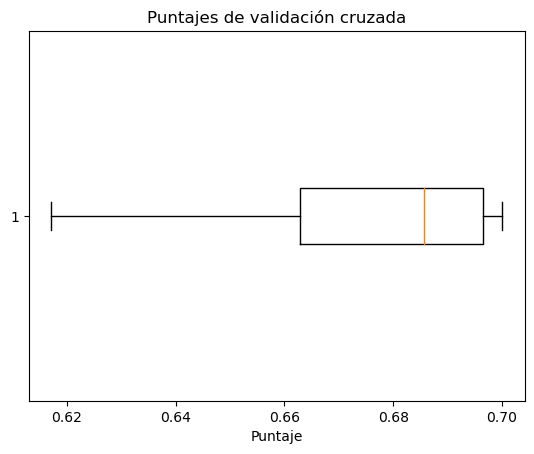

In [8]:
cv_results = clf.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

plt.boxplot(mean_scores, vert=False)
plt.title("Puntajes de validación cruzada")
plt.xlabel("Puntaje")
plt.show()

In [9]:
results = clf.cv_results_

df_results = pd.DataFrame({
    'params': results['params'],
    'mean_test_score': results['mean_test_score'],
    'std_test_score': results['std_test_score'],
    'rank_test_score': results['rank_test_score']})

df_results = df_results.sort_values(by=['rank_test_score'])
df_results

,params,mean_test_score,std_test_score,rank_test_score
9,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.700000,0.016288,1
0,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.698571,0.017728,2
6,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.697143,0.037417,3
2,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.694286,0.006999,4
3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.691429,0.022768,5
4,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.680000,0.047251,6
7,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.675714,0.035743,7
1,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.658571,0.045266,8
8,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.651429,0.030439,9
5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.617143,0.040051,10


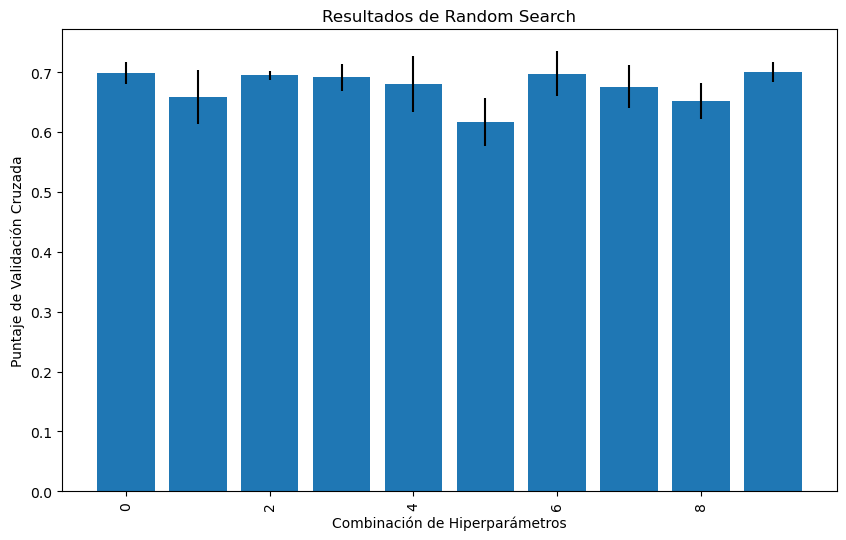

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Resultados de Random Search')
ax.set_xlabel('Combinación de Hiperparámetros')
ax.set_ylabel('Puntaje de Validación Cruzada')
ax.bar(df_results.index, df_results['mean_test_score'], yerr=df_results['std_test_score'])

plt.xticks(rotation=90)
plt.show()

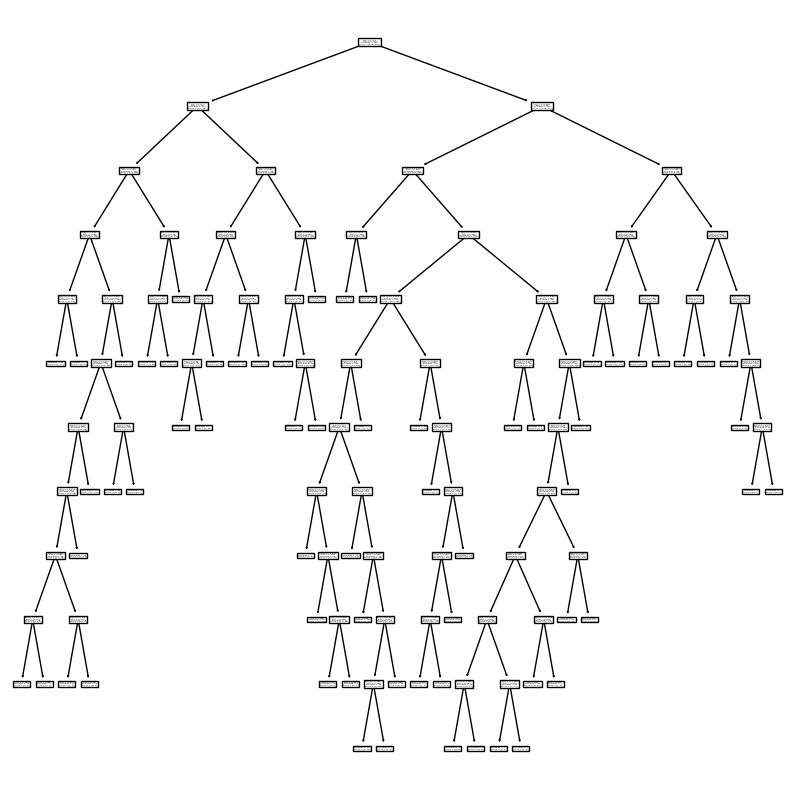

In [11]:
tree_clf = DecisionTreeClassifier(criterion= 'gini', max_depth = None, max_features = 3, min_samples_leaf = 7)
tree_clf.fit(X_train, y_train)

_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(tree_clf, ax=ax)

In [12]:
selector = SelectPercentile(f_classif)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)


tree_clf = DecisionTreeClassifier()
parameters = {"max_depth": [3, None],
              "max_features": randint(1, 4),
              "min_samples_leaf": randint(1, 10),
              "criterion": ["gini", "entropy"]}

clf = RandomizedSearchCV(tree_clf, 
                   parameters,
                   scoring = 'accuracy',
                   cv = 5,
                   return_train_score =  True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('El accuracy del arbol en el conjunto de test es de ' + str(accuracy_score(y_test, y_pred)))
print('Los mejores parametros fueron: ')
print(clf.best_params_)

results = clf.cv_results_

df_results = pd.DataFrame({
    'params': results['params'],
    'mean_test_score': results['mean_test_score'],
    'std_test_score': results['std_test_score'],
    'rank_test_score': results['rank_test_score']})

df_results = df_results.sort_values(by=['rank_test_score'])
df_results

El accuracy del arbol en el conjunto de test es de 0.7266666666666667
Los mejores parametros fueron: 
{'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 2}


,params,mean_test_score,std_test_score,rank_test_score
5,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.725714,0.017261,1
3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.721429,0.033806,2
6,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.721429,0.033806,2
8,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.721429,0.033806,2
1,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.701429,0.041991,5
7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.701429,0.041991,5
0,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.698571,0.034226,7
2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.698571,0.034226,7
4,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.697143,0.046642,9
9,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.697143,0.043939,10


In [13]:
tree_clf = DecisionTreeClassifier()
rfe = RFECV(estimator=tree_clf, step=1, min_features_to_select= 10, cv=5)

param_dist = {'estimator__criterion': ['gini', 'entropy'],
              'estimator__max_depth': randint(1, 6),
              'estimator__min_samples_split': randint(2, 11)}

pipe = Pipeline([('rfe', rfe), ('estimator', tree_clf)])
clf = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5)

clf.fit(X_train, y_train)

print('Mejores parámetros:', clf.best_params_)
print('Mejor puntaje:', clf.best_score_)

y_pred = clf.predict(X_test)
print('El accuracy del arbol en el conjunto de test es de ' + str(accuracy_score(y_test, y_pred)))
print('Los mejores parametros fueron: ')
print(clf.best_params_)

results = clf.cv_results_

Mejores parámetros: {'estimator__criterion': 'entropy', 'estimator__max_depth': 3, 'estimator__min_samples_split': 9}
Mejor puntaje: 0.7214285714285714
El accuracy del arbol en el conjunto de test es de 0.7166666666666667
Los mejores parametros fueron: 
{'estimator__criterion': 'entropy', 'estimator__max_depth': 3, 'estimator__min_samples_split': 9}


In [14]:
results = pd.DataFrame(clf.cv_results_)
cols = ['rank_test_score', 'params', 'mean_test_score', 'std_test_score']
results = results[cols].sort_values(by='mean_test_score', ascending=False)

results

,rank_test_score,params,mean_test_score,std_test_score
99,1,"{'estimator__criterion': 'gini', 'estimator__m...",0.721429,0.033806
57,1,"{'estimator__criterion': 'entropy', 'estimator...",0.721429,0.033806
65,1,"{'estimator__criterion': 'gini', 'estimator__m...",0.721429,0.033806
21,1,"{'estimator__criterion': 'gini', 'estimator__m...",0.721429,0.033806
22,1,"{'estimator__criterion': 'entropy', 'estimator...",0.721429,0.033806
...,...,...,...,...
32,96,"{'estimator__criterion': 'gini', 'estimator__m...",0.700000,0.043331
63,96,"{'estimator__criterion': 'gini', 'estimator__m...",0.700000,0.043331
11,96,"{'estimator__criterion': 'gini', 'estimator__m...",0.700000,0.043331
69,96,"{'estimator__criterion': 'gini', 'estimator__m...",0.700000,0.043331
